# Часть 2: Сравнение моделей

Этот ноутбук содержит:
- Функции генерации признаков
- Baseline модели (Naive, Seasonal Naive)
- Классические временные ряды (Holt-Winters, SARIMA)
- ML модели (Linear Regression, Random Forest, XGBoost, LightGBM)
- Глубокое обучение (LSTM)
- Сравнение метрик по всем моделям



## Загрузка данных


In [24]:
# === ИМПОРТЫ ===
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.gofplots import qqplot

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from prophet import Prophet

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

sys.path.append(str(Path().resolve().parent))  # Добавляем корень проекта в путь
from src.data.data_manager import DataManager
from src.data.feature_builder import (
    build_features_X_optimized,
    build_targets_multi_horizon,
    time_split_Xy
)


In [25]:
dm = DataManager()

# Получаем очищенные данные
df = dm.get_clean()

# Получаем ML признаки (View 2)
X, y = dm.get_ml_features_view()

# Создаём таргеты для разных горизонтов
targets = build_targets_multi_horizon(y, horizons=(1, 24, 168))

print(f"   Данные готовы: df.shape={df.shape}, X.shape={X.shape}")
print(f"   Признаки: {list(X.columns[:10])}... (всего {len(X.columns)})")

 Clean данные загружены из кеша: 35064 строк
 View 'ml_features' загружена из кеша: X.shape=(34896, 34)
   Данные готовы: df.shape=(35064, 1), X.shape=(34896, 34)
   Признаки: ['month', 'day_of_week', 'hour', 'is_weekend', 'day_of_year', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']... (всего 34)


In [28]:
def smape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred) + eps)
    
    return float(100.0 * np.mean(2.0 * numerator / denominator))

In [29]:
# разделяем данные на train, val, test
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.15)

train = df.iloc[:train_size]
val = df.iloc[train_size: train_size + val_size]
test = df.iloc[train_size + val_size:]


In [6]:
y_train = train['Usage_kWh']
y_val   = val['Usage_kWh']

Модель Seasonal Naive — это очень простая модель, которая предсказывает потребление энергии на основе значения 24 часа назад (предыдущий день, тот же час).
Модель требует исходный ряд.

In [7]:
def naive_shift_metrics(series, h):
    """
    Baseline: прогноз для момента t = значение h шагов назад.
    Для часовых данных:
      h=1   -> Naive (t+1)
      h=24  -> Seasonal Naive (t+24)
      h=168 -> Weekly Seasonal Naive (t+168)
    """
    y_pred = series.shift(h).dropna()
    y_true = series.loc[y_pred.index]
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    smape_pct = smape(y_true, y_pred)
    return mae, rmse, smape_pct

target = val['Usage_kWh']

naive_scores = {}

for h, name in [(1, "Seasonal Naive (час)"), (24, "Seasonal Naive (24 часа)"), (168, "Seasonal Naive (168 часов)")]:
    mae, rmse, smape_pct = naive_shift_metrics(target, h)

    naive_scores[h] = {
        "model": name,
        "MAE": mae,
        "RMSE": rmse,
        "sMAPE": smape_pct  
    }

    print(f"{name} (h={h}) — MAE: {mae:.2f} кВт·ч, RMSE: {rmse:.2f} кВт·ч, sMAPE: {smape_pct:.2f}%")

Seasonal Naive (час) (h=1) — MAE: 186.76 кВт·ч, RMSE: 255.11 кВт·ч, sMAPE: 20.19%
Seasonal Naive (24 часа) (h=24) — MAE: 152.65 кВт·ч, RMSE: 199.49 кВт·ч, sMAPE: 16.84%
Seasonal Naive (168 часов) (h=168) — MAE: 153.47 кВт·ч, RMSE: 200.47 кВт·ч, sMAPE: 16.93%


	•	Если более сложная модель даёт сильно меньшие значения MAE и RMSE, значит, она действительно лучше Seasonal Naive.
	•	Если разница мала или отсутствует — значит, ваша продвинутая модель не лучше простого “вчерашнего” прогноза, и её стоит пересмотреть.


**Holt-Winters (Triple Exponential Smoothing)**
Модель  требует исходный ряд.

In [20]:
def holt_winters_direct_metrics(train_series, eval_series, h, seasonal_periods=24,
                                trend='add', seasonal='add', damped_trend=True):
    model = ExponentialSmoothing(
        train_series,
        trend=trend,
        seasonal=seasonal,
        seasonal_periods=seasonal_periods,
        damped_trend=damped_trend
    ).fit()

    fc = model.forecast(steps=len(eval_series))  # прогноз "на весь val"

    y_true = eval_series.iloc[h:].values
    y_pred = fc.iloc[:-h].values

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    smape_pct = smape(y_true, y_pred)
    return mae, rmse, smape_pct


hw_scores = {}

for h in [1, 24, 168]:
    mae, rmse, smape_pct = holt_winters_direct_metrics(
        train_series=y_train,
        eval_series=y_val,
        h=h)

    hw_scores[h] = {
        "MAE": mae,
        "RMSE": rmse,
        "sMAPE": smape_pct
    }

    print(f"Holt-Winters (h={h}) — MAE: {mae:.2f} кВт·ч, RMSE: {rmse:.2f} кВт·ч, sMAPE: {smape_pct:.2f}%")

/Users/alice/Desktop/EnergyForecast/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Holt-Winters (h=1) — MAE: 178.99 кВт·ч, RMSE: 241.60 кВт·ч, sMAPE: 20.65%


/Users/alice/Desktop/EnergyForecast/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Holt-Winters (h=24) — MAE: 137.74 кВт·ч, RMSE: 174.05 кВт·ч, sMAPE: 16.03%


/Users/alice/Desktop/EnergyForecast/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Holt-Winters (h=168) — MAE: 138.07 кВт·ч, RMSE: 174.47 кВт·ч, sMAPE: 16.07%


**SARIMA**

In [21]:
# фиксируем частоту
y_train = y_train.asfreq("h")
y_val  = y_val.asfreq("h")


# ОДИН РАЗ обучаем модель
model = SARIMAX(
    y_train,
    order=(1, 0, 1),
    seasonal_order=(1, 1, 1, 24),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)


# ОДИН РАЗ делаем прогноз
y_forecast = model.forecast(steps=len(y_val))
y_forecast = pd.Series(y_forecast.values, index=y_val.index)


sarima_scores = {}
# считаем метрики по горизонтам
for h in (1, 24, 168):
    idx = y_val.index[h-1::h]

    y_true_h = y_val.loc[idx]
    y_pred_h = y_forecast.loc[idx]

    mae = mean_absolute_error(y_true_h, y_pred_h)
    rmse = np.sqrt(mean_squared_error(y_true_h, y_pred_h))
    smape_pct = smape(y_true_h, y_pred_h)

    sarima_scores[h] = {
        "MAE": mae,
        "RMSE": rmse,
        "sMAPE": smape_pct
    }

    print(f"SARIMA (h={h}) — MAE: {mae:.2f} кВт·ч, RMSE: {rmse:.2f} кВт·ч, sMAPE: {smape_pct:.2f}%")

SARIMA (h=1) — MAE: 117.52 кВт·ч, RMSE: 153.92 кВт·ч, sMAPE: 13.06%
SARIMA (h=24) — MAE: 125.06 кВт·ч, RMSE: 159.70 кВт·ч, sMAPE: 11.87%
SARIMA (h=168) — MAE: 132.89 кВт·ч, RMSE: 161.65 кВт·ч, sMAPE: 12.53%


                                     SARIMAX Results                                      
Dep. Variable:                          Usage_kWh   No. Observations:                24544
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 24)   Log Likelihood             -156465.265
Date:                            Wed, 07 Jan 2026   AIC                         312940.529
Time:                                    13:22:51   BIC                         312981.060
Sample:                                01-01-2017   HQIC                        312953.661
                                     - 10-20-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9266      0.005    192.828      0.000       0.917       0.936
ma.L1         -0.8000      0.007   

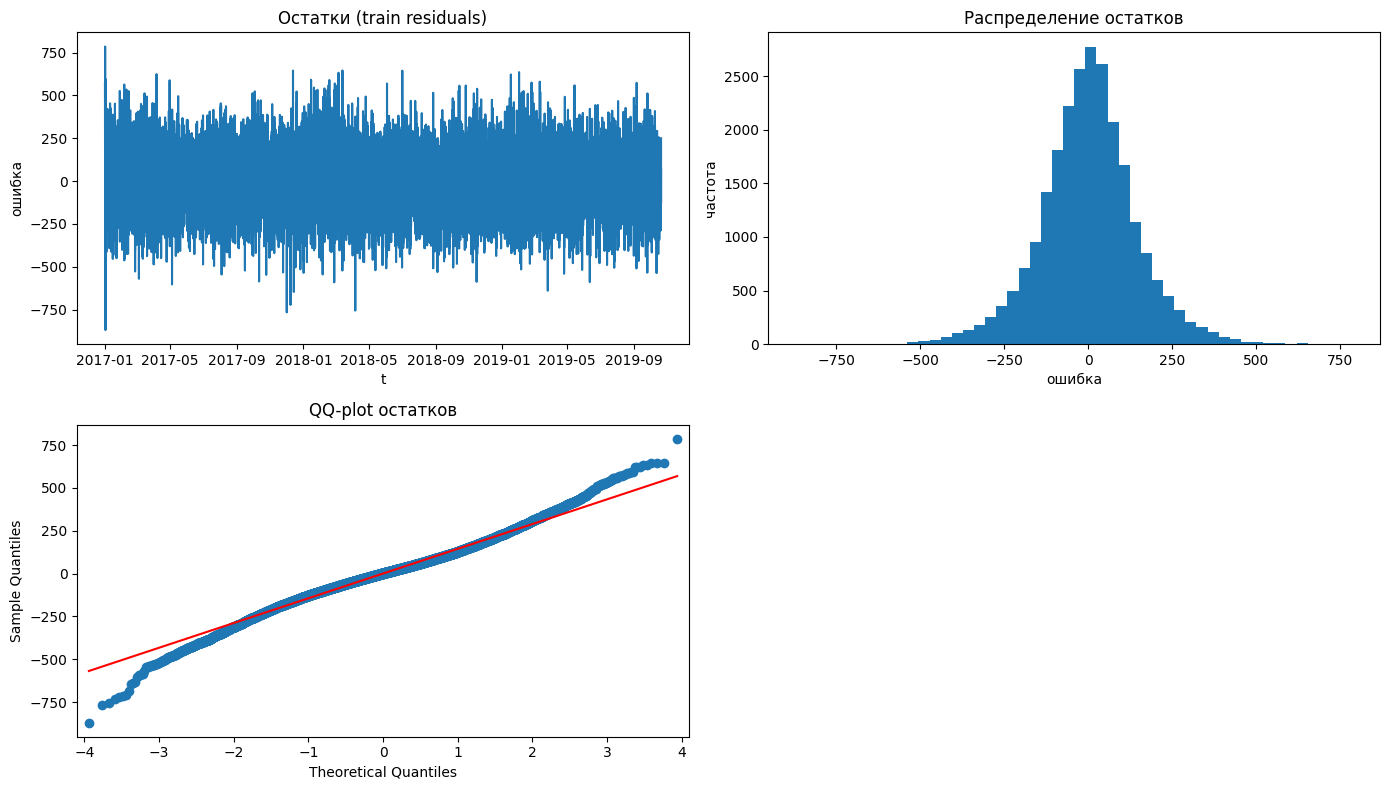

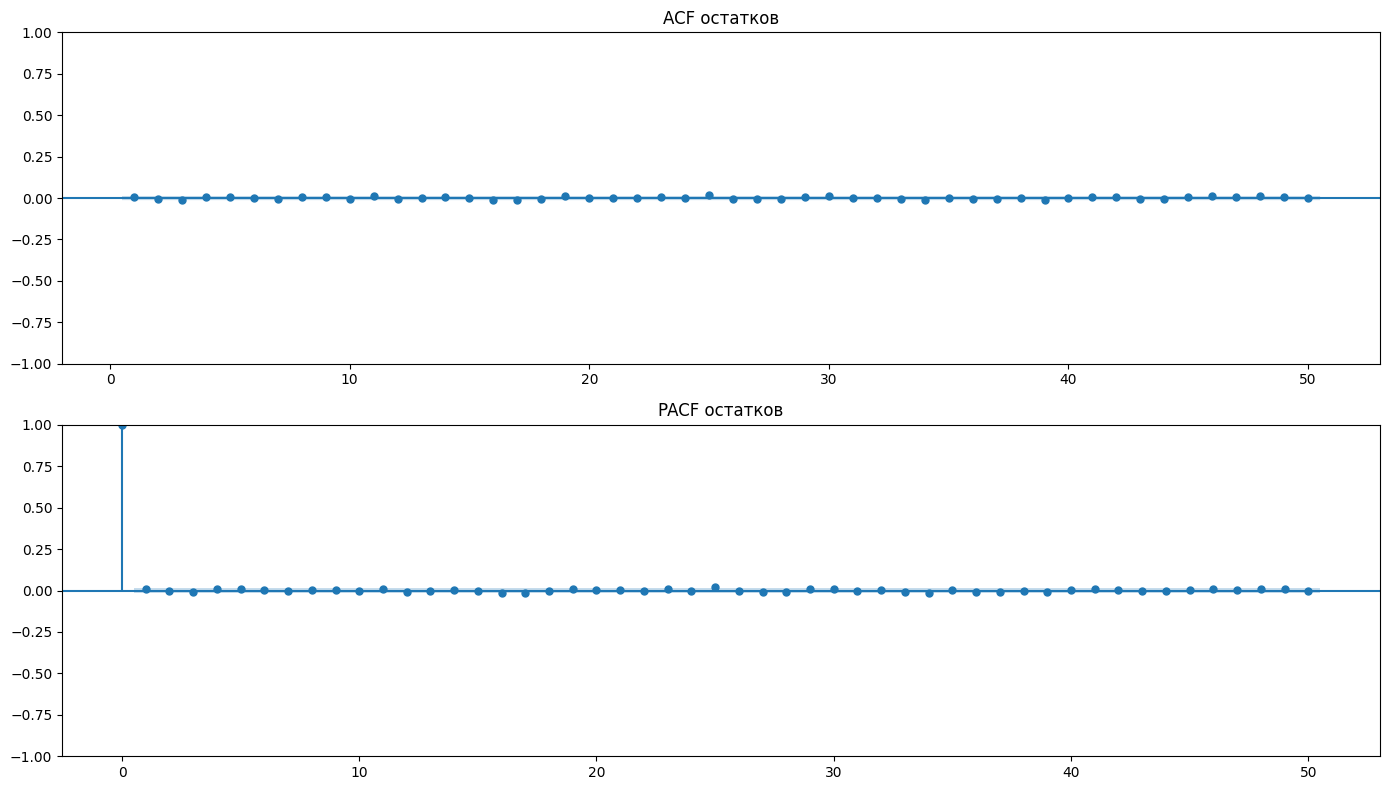

Ljung–Box test (H0: остатки без автокорреляции):
  lag= 24: lb_stat=   29.19, p-value=0.2130
  lag= 48: lb_stat=   65.69, p-value=0.0457
  lag= 72: lb_stat=   88.48, p-value=0.0909


In [15]:
def residual_diagnostics_sarimax(res,
                                 lags=50,
                                 ljungbox_lags=(24, 48, 72)):
    """
    res: SARIMAXResults (то есть результат .fit())
    """

    # 1) остатки (in-sample) — по обучающей части
    resid = pd.Series(res.resid, index=res.data.row_labels).dropna()

    # 2) график остатков + гистограмма + QQ-plot
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))

    axes[0, 0].plot(resid)
    axes[0, 0].set_title("Остатки (train residuals)")
    axes[0, 0].set_xlabel("t")
    axes[0, 0].set_ylabel("ошибка")

    axes[0, 1].hist(resid.values, bins=50)
    axes[0, 1].set_title("Распределение остатков")
    axes[0, 1].set_xlabel("ошибка")
    axes[0, 1].set_ylabel("частота")

    qqplot(resid.values, line="s", ax=axes[1, 0])
    axes[1, 0].set_title("QQ-plot остатков")

    axes[1, 1].axis("off")
    plt.tight_layout()
    plt.show()

    # 3) ACF/PACF остатков
    fig, axes = plt.subplots(2, 1, figsize=(14, 8))
    plot_acf(resid, lags=lags, ax=axes[0], alpha=0.05, zero=False)
    axes[0].set_title("ACF остатков")

    plot_pacf(resid, lags=lags, ax=axes[1], alpha=0.05, method="ywm")
    axes[1].set_title("PACF остатков")
    plt.tight_layout()
    plt.show()

    # 4) Ljung–Box (H0: нет автокорреляции остатков)
    lb = acorr_ljungbox(resid, lags=max(ljungbox_lags), return_df=True)

    print("Ljung–Box test (H0: остатки без автокорреляции):")
    for m in ljungbox_lags:
        stat = lb.loc[m, "lb_stat"]
        pval = lb.loc[m, "lb_pvalue"]
        print(f"  lag={m:>3}: lb_stat={stat:>8.2f}, p-value={pval:.4f}")

    return resid, lb

# ====== запуск ПОСЛЕ твоего обучения (model уже обучена) ======
print(model.summary())
resid, lb_table = residual_diagnostics_sarimax(
    model,
    lags=50,
    ljungbox_lags=(24, 48, 72)
)

In [8]:
def prepare_splits(
    X,
    targets,
    horizons=(1, 24, 168),
    train_ratio=0.7,
    val_ratio=0.15
):
    splits = {}

    for h in horizons:
        mask = targets[h]["mask"]

        X_h = X.loc[mask]
        y_h = targets[h]["y"].loc[mask]

        splits[h] = time_split_Xy(
            X_h, y_h,
            train_ratio=train_ratio,
            val_ratio=val_ratio
        )

    return splits


splits = prepare_splits(X, targets)

**Linear Regression**

In [9]:
def eval_lr_multi_horizon(
    splits,
    horizons=(1, 24, 168)
):
    results = {}

    for h in horizons:
        X_train, y_train, X_val, y_val, X_test, y_test = splits[h]

        model = Pipeline([
            ("scaler", StandardScaler()),
            ("lr", LinearRegression())
        ])

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        mae = mean_absolute_error(y_val, y_pred)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        smape_pct = smape(y_val, y_pred)

        results[h] = {
            "MAE": mae,
            "RMSE": rmse,
            "sMAPE": smape_pct
        }

        print(f"LR (h={h}) — MAE={mae:.2f}, RMSE={rmse:.2f}, sMAPE: {smape_pct:.2f}%")

    return results


lr_scores = eval_lr_multi_horizon(splits)

LR (h=1) — MAE=130.25, RMSE=168.65, sMAPE: 14.26%
LR (h=24) — MAE=122.74, RMSE=158.97, sMAPE: 13.47%
LR (h=168) — MAE=123.95, RMSE=161.40, sMAPE: 13.63%


**Random Forest**

In [11]:
def eval_rf_multi_horizon_from_splits(splits: dict, horizons=(1, 24, 168)):
    results = {}

    for h in horizons:
        X_train, y_train, X_val, y_val, X_test, y_test = splits[h]

        model = RandomForestRegressor()
        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)

        mae = mean_absolute_error(y_val, y_pred)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        smape_pct = smape(y_val, y_pred)

        results[h] = {
            "MAE": mae,
            "RMSE": rmse,
            "sMAPE": smape_pct,
            "n_train": len(X_train),
            "n_val": len(X_val),
            "n_test": len(X_test),
            "model": model
        }

        print(f"RandomForest (h={h}) — MAE: {mae:.2f} кВт·ч, RMSE: {rmse:.2f} кВт·ч, sMAPE: {smape_pct:.2f}%")

    return results


rf_scores = eval_rf_multi_horizon_from_splits(splits)


RandomForest (h=1) — MAE: 110.05 кВт·ч, RMSE: 144.70 кВт·ч, sMAPE: 12.03%
RandomForest (h=24) — MAE: 113.21 кВт·ч, RMSE: 147.31 кВт·ч, sMAPE: 12.37%
RandomForest (h=168) — MAE: 111.67 кВт·ч, RMSE: 146.04 кВт·ч, sMAPE: 12.18%


**XGBoost**

In [12]:
def eval_xgb_multi_horizon_from_splits(
    splits: dict,
    horizons=(1, 24, 168)
):
    results = {}

    for h in horizons:
        X_train, y_train, X_val, y_val, X_test, y_test = splits[h]

        model = XGBRegressor()
        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)

        mae = mean_absolute_error(y_val, y_pred)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        smape_pct = smape(y_val, y_pred)

        results[h] = {
            "MAE": mae,
            "RMSE": rmse,
            "sMAPE": smape_pct,
            "n_train": len(X_train),
            "n_val": len(X_val),
            "n_test": len(X_test),
            "model": model
        }

        print(f"XGBoost (h={h}) — MAE: {mae:.2f} кВт·ч, RMSE: {rmse:.2f} кВт·ч, sMAPE: {smape_pct:.2f}%")

    return results


xgb_scores = eval_xgb_multi_horizon_from_splits(splits)


XGBoost (h=1) — MAE: 115.28 кВт·ч, RMSE: 152.24 кВт·ч, sMAPE: 12.67%
XGBoost (h=24) — MAE: 122.94 кВт·ч, RMSE: 161.15 кВт·ч, sMAPE: 13.38%
XGBoost (h=168) — MAE: 117.26 кВт·ч, RMSE: 154.49 кВт·ч, sMAPE: 12.78%


**LightGBM**

In [13]:
def eval_lgbm_multi_horizon_from_splits(
    splits: dict,
    horizons=(1, 24, 168)
):
    results = {}

    for h in horizons:
        X_train, y_train, X_val, y_val, X_test, y_test = splits[h]

        model = LGBMRegressor()
        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)

        mae = mean_absolute_error(y_val, y_pred)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        smape_pct = smape(y_val, y_pred)

        results[h] = {
            "MAE": mae,
            "RMSE": rmse,
            "sMAPE": smape_pct,
            "n_train": len(X_train),
            "n_val": len(X_val),
            "n_test": len(X_test),
            "model": model
        }

        print(f"LightGBM (h={h}) — MAE: {mae:.2f} кВт·ч, RMSE: {rmse:.2f} кВт·ч, sMAPE: {smape_pct:.2f}%")

    return results


lgbm_scores = eval_lgbm_multi_horizon_from_splits(splits)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7696
[LightGBM] [Info] Number of data points in the train set: 24426, number of used features: 34
[LightGBM] [Info] Start training from score 914.460683
LightGBM (h=1) — MAE: 109.60 кВт·ч, RMSE: 143.88 кВт·ч, sMAPE: 12.03%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001856 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7696
[LightGBM] [Info] Number of data points in the train set: 24410, number of used features: 34
[LightGBM] [Info] Start training from score 914.394715
LightGBM (h=24) — MAE: 112.93 кВт·ч, RMSE: 147.21 кВт·ч, sMAPE: 12.32%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM

**Prophet**


In [26]:
dfp = dm.get_prophet_view()

 View 'prophet' загружена из кеша: 35064 строк


In [27]:
dfp.isna().sum()

ds    0
y     0
dtype: int64

In [28]:
def time_split_prophet_df(dfp: pd.DataFrame, train_ratio=0.7, val_ratio=0.15):
    dfp = dfp.sort_values("ds").reset_index(drop=True)

    n = len(dfp)
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))

    train_p = dfp.iloc[:train_end].copy()
    val_p   = dfp.iloc[train_end:val_end].copy()
    test_p  = dfp.iloc[val_end:].copy()

    return train_p, val_p, test_p

In [29]:
def eval_prophet_multi_horizon_correct_from_splits(
    train_p,
    val_p,
    horizons=(1, 24, 168),
    prophet_params=None
):
    if prophet_params is None:
        prophet_params = dict(
            daily_seasonality=True,
            weekly_seasonality=True,
            yearly_seasonality=False
        )

    # защитимся от NaN
    train_p = train_p.dropna(subset=["y"]).copy()
    val_p   = val_p.dropna(subset=["y"]).copy()

    m = Prophet(**prophet_params)
    m.fit(train_p[["ds", "y"]])

    results = {}
    for h in horizons:
        if len(val_p) < h:
            raise ValueError(f"val_p слишком короткий для h={h}: len(val_p)={len(val_p)}")

        future = m.make_future_dataframe(periods=h, freq="H", include_history=False)
        fc = m.predict(future)

        y_pred = fc["yhat"].values
        y_true = val_p["y"].iloc[:h].values

        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        smape_pct = smape(y_true, y_pred)

        results[h] = {"MAE": mae, "RMSE": rmse, "sMAPE": smape_pct}
        print(f"Prophet (h={h}) — MAE: {mae:.2f}, RMSE: {rmse:.2f}, sMAPE: {smape_pct:.2f}%")

    return results

In [30]:
train_p, val_p, test_p = time_split_prophet_df(dfp)

prophet_scores = eval_prophet_multi_horizon_correct_from_splits(
    train_p, val_p)

13:27:36 - cmdstanpy - INFO - Chain [1] start processing
13:27:43 - cmdstanpy - INFO - Chain [1] done processing


Prophet (h=1) — MAE: 115.14, RMSE: 115.14, sMAPE: 11.34%
Prophet (h=24) — MAE: 156.10, RMSE: 206.32, sMAPE: 18.96%
Prophet (h=168) — MAE: 124.52, RMSE: 166.52, sMAPE: 14.16%


/Users/alice/Desktop/EnergyForecast/venv/lib/python3.12/site-packages/prophet/forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
/Users/alice/Desktop/EnergyForecast/venv/lib/python3.12/site-packages/prophet/forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
/Users/alice/Desktop/EnergyForecast/venv/lib/python3.12/site-packages/prophet/forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


**LSTM**

In [14]:
dfl = dm.get_lstm_base_view()

 View 'lstm_base' загружена из кеша: 35064 строк


In [33]:
# def make_lstm_supervised_multioutput(
#     y_scaled: np.ndarray,
#     window_size: int,
#     horizons=(1, 24, 168)
# ):

#     hs = sorted(horizons)
#     max_h = hs[-1]

#     X, Y = [], []
#     for t in range(window_size, len(y_scaled) - max_h + 1):
#         x_win = y_scaled[t-window_size:t, 0]
#         y_vec = [y_scaled[t + (h - 1), 0] for h in hs]
#         X.append(x_win)
#         Y.append(y_vec)

#     X = np.array(X, dtype=np.float32).reshape(-1, window_size, 1)
#     Y = np.array(Y, dtype=np.float32)
#     return X, Y, hs


# def eval_lstm_multi_horizon_one_model(
#     df: pd.DataFrame,
#     target_col="Usage_kWh",
#     horizons=(1, 24, 168),
#     window_size=168,
#     train_ratio=0.7,
#     val_ratio=0.15,
#     epochs=50,
#     batch_size=64,
#     lstm_units=64,
#     dense_units=32,
#     learning_rate=1e-3,
#     seed=42
# ):


#     # фиксируем сиды
#     np.random.seed(seed)
#     tf.random.set_seed(seed)

#     # 1) ряд
#     y = df[target_col].copy()
#     y = y.sort_index().asfreq("h")
#     y = y.astype(np.float32)

#     # 2) split по времени (по индексам ряда)
#     n = len(y)
#     train_end = int(n * train_ratio)
#     val_end = int(n * (train_ratio + val_ratio))

#     y_train = y.iloc[:train_end].values.reshape(-1, 1)
#     y_val   = y.iloc[train_end:val_end].values.reshape(-1, 1)
#     # y_test  = y.iloc[val_end:].values.reshape(-1, 1)

#     # 3) scale (LSTM обычно требует нормализацию) [Практика]
#     scaler = MinMaxScaler()
#     y_train_scaled = scaler.fit_transform(y_train)
#     y_val_scaled   = scaler.transform(y_val)

#     # 4) supervised датасеты
#     X_train, Y_train, hs = make_lstm_supervised_multioutput(
#         y_train_scaled, window_size=window_size, horizons=horizons
#     )
#     X_val, Y_val, _ = make_lstm_supervised_multioutput(
#         y_val_scaled, window_size=window_size, horizons=horizons
#     )

#     # 5) модель
#     model = Sequential([
#         Input(shape=(window_size, 1)),
#         LSTM(lstm_units, return_sequences=False),
#         Dense(dense_units, activation="relu"),
#         Dense(len(horizons))
#     ])

#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
#         loss="mse"
#     )

#     es = EarlyStopping(
#         monitor="val_loss",
#         patience=5,
#         restore_best_weights=True
#     )

#     model.fit(
#         X_train, Y_train,
#         validation_data=(X_val, Y_val),
#         epochs=epochs,
#         batch_size=batch_size,
#         callbacks=[es],
#         verbose=2
#     )

#     # 6) прогноз на val
#     Y_pred_scaled = model.predict(X_val)

#     # 7) обратно в kWh: scaler был для одного столбца, поэтому делаем inverse_transform по каждому горизонту отдельно
#     results = {}

#     for j, h in enumerate(hs):
#         y_true_h_scaled = Y_val[:, j].reshape(-1, 1)
#         y_pred_h_scaled = Y_pred_scaled[:, j].reshape(-1, 1)

#         y_true_h = scaler.inverse_transform(y_true_h_scaled).ravel()
#         y_pred_h = scaler.inverse_transform(y_pred_h_scaled).ravel()

#         mae = mean_absolute_error(y_true_h, y_pred_h)
#         rmse = np.sqrt(mean_squared_error(y_true_h, y_pred_h))
#         smape_pct = smape(y_true_h, y_pred_h)

#         results[h] = {"MAE": mae, "RMSE": rmse, "sMAPE": smape_pct}
#         print(f"LSTM (h={h}) — MAE: {mae:.2f} кВт·ч, RMSE: {rmse:.2f} кВт·ч, sMAPE: {smape_pct:.2f}%")

#     return results, model, scaler


# # пример запуска
# lstm_scores, lstm_model, lstm_scaler = eval_lstm_multi_horizon_one_model(
#     dfl,
#     window_size=168
# )

In [22]:
ALL_METRICS = []


def add_scores(model_name: str, scores: dict, split: str = "val"):
    if scores is None:
        return

    for k, v in scores.items():
        if isinstance(k, str) and k.lower().startswith("h="):
            h = int(k.split("=")[1])
        else:
            h = int(k)

        if not isinstance(v, dict):
            continue

        ALL_METRICS.append({
            "model": str(model_name),   #  ТОЛЬКО СТРОКА
            "split": split,
            "horizon": int(h),
            "MAE": float(v.get("MAE")),
            "RMSE": float(v.get("RMSE"))
        })


def build_summary_tables(df_metrics: pd.DataFrame, split: str = "val"):
    raw_df = df_metrics.copy()

    raw_df = raw_df[raw_df["split"] == split].copy()


    raw_df["horizon"] = raw_df["horizon"].astype(int)
    raw_df = raw_df.sort_values(["model", "horizon"])

    mae_pivot = raw_df.pivot_table(
        index="model",
        columns="horizon",
        values="MAE",
        aggfunc="mean"
    ).sort_index()

    rmse_pivot = raw_df.pivot_table(
        index="model",
        columns="horizon",
        values="RMSE",
        aggfunc="mean"
    ).sort_index()

    mae_pivot.columns = [f"h={c}" for c in mae_pivot.columns]
    rmse_pivot.columns = [f"h={c}" for c in rmse_pivot.columns]

    return raw_df, mae_pivot, rmse_pivot

In [23]:
add_scores("Naive/SeasonalNaive", naive_scores, split="val")
add_scores("Holt-Winters", hw_scores, split="val")
add_scores("SARIMA", sarima_scores, split="val")

add_scores("LinearRegression", lr_scores, split="val")
add_scores("RandomForest", rf_scores, split="val")
add_scores("XGBoost", xgb_scores, split="val")
add_scores("LightGBM", lgbm_scores, split="val")


add_scores("Prophet", prophet_scores, split="val")
# add_scores("LSTM", lstm_scores, split="val")

NameError: name 'prophet_scores' is not defined

In [ ]:
df_metrics = pd.DataFrame(ALL_METRICS)

raw_df, mae_table, rmse_table = build_summary_tables(df_metrics, split="val")

print("RAW (val):")
display(raw_df)

print("MAE table (val):")
display(mae_table)

print("RMSE table (val):")
display(rmse_table)